# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [ ]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [7]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node). 

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [8]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [9]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [10]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [11]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [12]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cpu
Epoch 00001 | Loss: 0.6365
F1-Score: 0.4434
Epoch 00002 | Loss: 0.5807
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5558
Epoch 00005 | Loss: 0.5504
Epoch 00006 | Loss: 0.5458
F1-Score: 0.4993
Epoch 00007 | Loss: 0.5417
Epoch 00008 | Loss: 0.5373
Epoch 00009 | Loss: 0.5338
Epoch 00010 | Loss: 0.5311
Epoch 00011 | Loss: 0.5284
F1-Score: 0.5215
Epoch 00012 | Loss: 0.5257
Epoch 00013 | Loss: 0.5231
Epoch 00014 | Loss: 0.5207
Epoch 00015 | Loss: 0.5183
Epoch 00016 | Loss: 0.5160
F1-Score: 0.5341
Epoch 00017 | Loss: 0.5138
Epoch 00018 | Loss: 0.5116
Epoch 00019 | Loss: 0.5095
Epoch 00020 | Loss: 0.5074
Epoch 00021 | Loss: 0.5054
F1-Score: 0.5442
Epoch 00022 | Loss: 0.5033
Epoch 00023 | Loss: 0.5013
Epoch 00024 | Loss: 0.4994
Epoch 00025 | Loss: 0.4976
Epoch 00026 | Loss: 0.4958
F1-Score: 0.5544
Epoch 00027 | Loss: 0.4942
Epoch 00028 | Loss: 0.4927
Epoch 00029 | Loss: 0.4913
Epoch 00030 | Loss: 0.4902
Epoch 00031 | Loss: 0.4891
F1-Score: 0.5528
Epoch 00032 | Loss: 0.4873
Epo

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6305


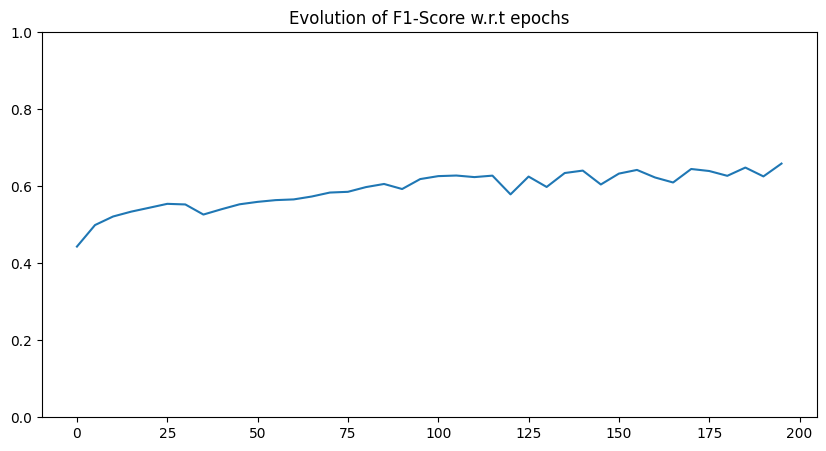

In [13]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files : 
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights
 
 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.
 
Intermediate question : 

 Provide the script for training, and a plot of the training loss.  

In [14]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv


class StudentModel(nn.Module):
    """
    GAT model faithful to:
    Velickovic et al., 'Graph Attention Networks', ICLR 2018 (PPI setup)

    This model implements a 3-layer Graph Attention Network (GAT) with a skip
    connection between the first and second hidden layers.

    Parameters
    ----------
    input_size : int, optional
        Dimensionality of input features. Defaults to `n_features`.
    hidden_size : int, optional
        Dimensionality of the hidden layers (per head). Defaults to 256.
    output_size : int, optional
        Dimensionality of the output classes. Defaults to 121.
    heads_1 : int, optional
        Number of attention heads for the first layer. Defaults to 4.
    heads_2 : int, optional
        Number of attention heads for the second layer. Defaults to 4.
    heads_3 : int, optional
        Number of attention heads for the output layer. Defaults to 6.
    """

    def __init__(
        self,
        input_size=n_features,
        hidden_size=256,
        output_size=121,
        heads_1=4,
        heads_2=4,
        heads_3=6,
    ):
        super().__init__()

        self.elu = nn.ELU()

        # Layer 1
        # K=4 heads, F'=256, concat=True
        self.conv1 = GATConv(
            input_size,
            hidden_size,
            heads=heads_1,
            concat=True,
        )

        # Layer 2
        # K=4 heads, F'=256, concat=True
        self.conv2 = GATConv(
            hidden_size * heads_1,
            hidden_size,
            heads=heads_2,
            concat=True,
        )

        self.lin_skip = nn.Linear(
            hidden_size * heads_1,
            hidden_size * heads_2,
            bias=False,
        )

        # Final layer (Classifier)
        # K=6 heads, F'=121
        self.conv3 = GATConv(
            hidden_size * heads_2,
            output_size,
            heads=heads_3,
            concat=False,
        )

    def forward(self, x, edge_index):
        """
        Performs the forward pass of the model.

        Parameters
        ----------
        x : torch.Tensor
            Node feature matrix of shape `(num_nodes, input_size)`.
        edge_index : torch.Tensor
            Graph connectivity in COO format of shape `(2, num_edges)`.

        Returns
        -------
        torch.Tensor
            The output logits of shape `(num_nodes, output_size)`.
        """
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.elu(x)

        # Layer 2
        x_in = x
        x = self.conv2(x, edge_index)
        x = self.elu(x)

        # Skip connection
        x = x + self.lin_skip(x_in)

        # Final layer (logits)
        x = self.conv3(x, edge_index)

        return x

### Training function

In [31]:
# New Train function adapted to return loss_history for the required plot
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):
    epoch_list = []
    scores_list = []
    loss_history = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        loss_data = np.array(losses).mean()
        loss_history.append(loss_data)
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if (epoch + 1) % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see function above)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list, loss_history

### Plotting training loss, validation score and saving model

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Definition (GAT)
model = StudentModel(
    input_size=n_features,
    hidden_size=350,
    output_size=n_classes,
    heads_1=4,
    heads_2=4,
    heads_3=6,
).to(device)

# Loss and Optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Train
max_epochs = 300
epoch_list, scores_list, loss_history = train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
)

# Plotting
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Evolution")
plt.legend()

# Plot Validation F1-Score
plt.subplot(1, 2, 2)
plt.plot(epoch_list, scores_list, color="orange", label="Val F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1-Score Evolution")
plt.ylim(0, 1.0)
plt.legend()

plt.show()

# Save Model
# torch.save(model.state_dict(), "model.pth")
# print("Model saved to model.pth")

### Test: Evaluating final score on validation and test datasets

In [16]:
from class_model_gnn import StudentModel, evaluate, val_dataloader, test_dataloader

# Load Model and Evaluate on Val and Test Sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StudentModel(
    input_size=50,
    hidden_size=350,
    output_size=121,
    heads_1=4,
    heads_2=4,
    heads_3=6,
).to(device)

loss_fcn = nn.BCEWithLogitsLoss()

state_dict = torch.load("model.pth", map_location=device)
model.load_state_dict(state_dict)

val_scores = evaluate(model, loss_fcn, device, val_dataloader)
print("Final GAT Model : F1-Score on the val set: {:.4f}".format(val_scores))

test_score = evaluate(model, loss_fcn, device, test_dataloader)
print("Final GAT Model : F1-Score on the test set: {:.4f}".format(test_score))

Final GAT Model : F1-Score on the val set: 0.9302
Final GAT Model : F1-Score on the test set: 0.9547


## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ : 

$$ \gamma_\Theta : x,y \mapsto y $$


In [17]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [18]:
def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    # Assumptions (remove it for the bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, (
            "Expected padding of 1 on both sides."
        )
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, (
            "Expected kernel size of 3x3."
        )
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    kernel_size = 3
    padding = 1

    C, H, W = image.shape

    # Node features (each pixel is a node)
    x = image.view(C, -1).T

    # Edge index and edge attributes
    edge_list = []
    edge_attr_list = []

    half_k = kernel_size // 2
    kernel_points = [
        (i - half_k, j - half_k) for i in range(kernel_size) for j in range(kernel_size)
    ]

    for i in range(H):
        for j in range(W):
            node_idx = i * W + j
            for di, dj in kernel_points:
                ni, nj = i + di, j + dj
                if 0 <= ni < H and 0 <= nj < W:
                    neighbor_idx = ni * W + nj
                    edge_list.append((neighbor_idx, node_idx))
                    # Store relative position as edge attribute but shifted to start from (0,0)
                    edge_attr_list.append((dj + half_k, di + half_k))

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_attr_list = torch.tensor(edge_attr_list, dtype=torch.float)

    data = torch_geometric.data.Data(
        x=x, edge_index=edge_index, edge_attr=edge_attr_list
    )

    return data

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [19]:
def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    # Assumptions (remove it for the bonus)
    assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, (
            "Expected padding of 1 on both sides."
        )
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, (
            "Expected kernel size of 3x3."
        )
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    # Checking if there is no mismatch in dimensions
    N, C = data.shape
    assert N == height * width, (
        f"Data has {N} nodes, but expected {height * width} nodes."
    )

    image = data.T.view(C, height, width)

    return image

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [20]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism. 
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [21]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        # Initialize the MessagePassing class with sum aggregation to simulate convolution over neighbors
        super().__init__(aggr="add")

        # Store the Conv2d layer and its weights
        self.conv2d = conv2d
        self.weights = conv2d.weight

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """

        col_idx = edge_attr[:, 0].long()
        row_idx = edge_attr[:, 1].long()

        weights = self.weights[:, :, row_idx, col_idx]
        weights = weights.permute(2, 1, 0)

        message = torch.bmm(x_j.unsqueeze(1), weights).squeeze(1)

        return message


## Test example

In [22]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)
